# How to pivot from long to wide format

Data is returned as a long format, dataframe. This means there is one unique observation (air temperature, humidity, wind speed, etc.) per row. It's often useful to pivot variables into columns. This can be done with Polars. I encourage users of SynopticPy to become familiar with Polars for DataFrame manipulation.

In [131]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from herbie.toolbox import EasyMap, ccrs, pc

import synoptic

In [24]:
s = synoptic.Latest(stid="ukbkb,wbb", vars="air_temp,dew_point_temperature")
df = s.df
df

🚚💨 Speedy delivery from Synoptic latest service.
📦 Received data from 2 stations.


date_time,variable,sensor,derived,value,units,id,stid,name,elevation,latitude,longitude,mnet_id,state,timezone,elev_dem,period_of_record_start,period_of_record_end,is_restricted,is_active
"datetime[μs, UTC]",str,u32,bool,f64,str,u32,str,str,f64,f64,f64,u32,str,str,f64,"datetime[μs, UTC]","datetime[μs, UTC]",bool,bool
2024-09-14 20:55:00 UTC,"""air_temp""",1,false,28.8,"""Celsius""",1,"""WBB""","""U of U William Browning Buildi…",4806.0,40.76623,-111.84755,153,"""UT""","""America/Denver""",4727.7,1997-01-01 00:00:00 UTC,2024-09-14 20:20:00 UTC,false,true
2024-09-14 20:55:00 UTC,"""dew_point_temperature""",1,true,-2.83,"""Celsius""",1,"""WBB""","""U of U William Browning Buildi…",4806.0,40.76623,-111.84755,153,"""UT""","""America/Denver""",4727.7,1997-01-01 00:00:00 UTC,2024-09-14 20:20:00 UTC,false,true
2024-09-14 20:45:00 UTC,"""air_temp""",1,false,29.444,"""Celsius""",37032,"""UKBKB""","""EW2355 Spanish Fork""",4734.0,40.09867,-111.62767,65,"""UT""","""America/Denver""",4740.8,2013-03-13 00:00:00 UTC,2024-09-14 20:15:00 UTC,false,true
2024-09-14 20:45:00 UTC,"""dew_point_temperature""",1,true,2.72,"""Celsius""",37032,"""UKBKB""","""EW2355 Spanish Fork""",4734.0,40.09867,-111.62767,65,"""UT""","""America/Denver""",4740.8,2013-03-13 00:00:00 UTC,2024-09-14 20:15:00 UTC,false,true


In [26]:
df.pivot(
    on="variable",
    index=["date_time", "stid", "latitude", "longitude", "elevation"],
    values="value",
)

date_time,stid,latitude,longitude,elevation,air_temp,dew_point_temperature
"datetime[μs, UTC]",str,f64,f64,f64,f64,f64
2024-09-14 20:55:00 UTC,"""WBB""",40.76623,-111.84755,4806.0,28.8,-2.83
2024-09-14 20:45:00 UTC,"""UKBKB""",40.09867,-111.62767,4734.0,29.444,2.72


## Special Case: Multiple Sensors

If your set of stations has multiple sensors the measure the same variable (e.g., NAA measures outdoor air temperature and greenhouse air temperature) you will need to take care with how you perform your pivot. Either filter the rows for a single sensor ID, or pivot on both the variable _and_ sensor columns.

In [44]:
# Notice that NAA has two different reports for air temperature
df = synoptic.Latest(stid="naa", vars="air_temp,wind_speed").df
df

🚚💨 Speedy delivery from Synoptic latest service.
📦 Received data from 1 stations.


date_time,variable,sensor,derived,value,units,id,stid,name,elevation,latitude,longitude,mnet_id,state,timezone,elev_dem,period_of_record_start,period_of_record_end,is_restricted,is_active
"datetime[μs, UTC]",str,u32,bool,f64,str,u32,str,str,f64,f64,f64,u32,str,str,f64,"datetime[μs, UTC]","datetime[μs, UTC]",bool,bool
2024-09-14 21:05:00 UTC,"""air_temp""",1,false,28.611,"""Celsius""",43136,"""NAA""","""Neil Armstrong Academy""",4260.0,40.71152,-112.01448,153,"""UT""","""America/Denver""",4252.0,2014-05-27 00:00:00 UTC,2024-09-14 21:45:00 UTC,false,true
2024-09-14 21:05:00 UTC,"""air_temp""",2,false,36.833,"""Celsius""",43136,"""NAA""","""Neil Armstrong Academy""",4260.0,40.71152,-112.01448,153,"""UT""","""America/Denver""",4252.0,2014-05-27 00:00:00 UTC,2024-09-14 21:45:00 UTC,false,true
2024-09-14 21:05:00 UTC,"""wind_speed""",1,false,2.228,"""m/s""",43136,"""NAA""","""Neil Armstrong Academy""",4260.0,40.71152,-112.01448,153,"""UT""","""America/Denver""",4252.0,2014-05-27 00:00:00 UTC,2024-09-14 21:45:00 UTC,false,true


In [46]:
# Filter sensor ID, then pivot
df.filter(sensor=1).pivot(
    "variable", index=["stid", "date_time", "latitude", "longitude"], values="value"
)

stid,date_time,latitude,longitude,air_temp,wind_speed
str,"datetime[μs, UTC]",f64,f64,f64,f64
"""NAA""",2024-09-14 21:05:00 UTC,40.71152,-112.01448,28.611,2.228


In [48]:
# Pivot on both variable and sensor column
df.pivot(
    ["variable", "sensor"],
    index=["stid", "date_time", "latitude", "longitude"],
    values="value",
)

stid,date_time,latitude,longitude,"{""air_temp"",1}","{""air_temp"",2}","{""wind_speed"",1}"
str,"datetime[μs, UTC]",f64,f64,f64,f64,f64
"""NAA""",2024-09-14 21:05:00 UTC,40.71152,-112.01448,28.611,36.833,2.228


## Special Case: Measured and derived values

Some stations have both measured and derived variables, like dew point temperature. Your pivot options are 
1. Filter to use only the measured value
1. Pivot on both `variable` _and_ `derived` columns.
1. Use an aggregattion function to take **mean** or **first** of the two values.

In [79]:
df = synoptic.Latest(stid="KU69", vars="wind_speed,dew_point_temperature").df
df

🚚💨 Speedy delivery from Synoptic latest service.
📦 Received data from 1 stations.


date_time,variable,sensor,derived,value,units,id,stid,name,elevation,latitude,longitude,mnet_id,state,timezone,elev_dem,period_of_record_start,period_of_record_end,is_restricted,is_active
"datetime[μs, UTC]",str,u32,bool,f64,str,u32,str,str,f64,f64,f64,u32,str,str,f64,"datetime[μs, UTC]","datetime[μs, UTC]",bool,bool
2024-09-14 20:55:00 UTC,"""dew_point_temperature""",1,false,-4.0,"""Celsius""",6470,"""KU69""","""DUCHESNE""",5826.0,40.1919,-110.38099,1,"""UT""","""America/Denver""",5810.4,2007-10-11 00:00:00 UTC,2024-09-14 20:35:00 UTC,false,true
2024-09-14 20:55:00 UTC,"""wind_speed""",1,false,3.601,"""m/s""",6470,"""KU69""","""DUCHESNE""",5826.0,40.1919,-110.38099,1,"""UT""","""America/Denver""",5810.4,2007-10-11 00:00:00 UTC,2024-09-14 20:35:00 UTC,false,true
2024-09-14 20:55:00 UTC,"""dew_point_temperature""",1,true,-3.95,"""Celsius""",6470,"""KU69""","""DUCHESNE""",5826.0,40.1919,-110.38099,1,"""UT""","""America/Denver""",5810.4,2007-10-11 00:00:00 UTC,2024-09-14 20:35:00 UTC,false,true


In [88]:
# Pivot, calculate the mean if more than one value per variable
df.pivot("variable", index="stid", values="value", aggregate_function="mean")

stid,dew_point_temperature,wind_speed
str,f64,f64
"""KU69""",-3.975,3.601


In [84]:
# Pivot, use the first value if more than one value per variable
df.pivot("variable", index="stid", values="value", aggregate_function="first")

stid,dew_point_temperature,wind_speed
str,f64,f64
"""KU69""",-4.0,3.601


In [92]:
# Piovot on both variable and derived columns
df.sort("variable").pivot(
    ["variable", "derived"],
    index=["stid", "latitude", "longitude"],
    values="value",
)

stid,latitude,longitude,"{""dew_point_temperature"",false}","{""dew_point_temperature"",true}","{""wind_speed"",false}"
str,f64,f64,f64,f64,f64
"""KU69""",40.1919,-110.38099,-4.0,-3.95,3.601


## Pivot many station variables
Let's pivot requests with more station data...

In [176]:
df = synoptic.Latest(
    state="UT",
    network=[1, 2],
    vars="air_temp,dew_point_temperature",
    units="english",
    complete=1,  # to get mesonest shortname
).df

# Pivot
df = df.pivot(
    "variable",
    index=["stid", "latitude", "longitude", "shortname"],
    values="value",
    aggregate_function="first",
)
df

🚚💨 Speedy delivery from Synoptic latest service.
📦 Received data from 128 stations.


stid,latitude,longitude,shortname,air_temp,dew_point_temperature
str,f64,f64,str,f64,f64
"""KSLC""",40.77069,-111.96503,"""ASOS/AWOS""",69.98,35.89
"""KU42""",40.6196,-111.99016,"""ASOS/AWOS""",68.18,28.22
"""KHIF""",41.11112,-111.96229,"""ASOS/AWOS""",67.46,26.06
"""KOGD""",41.19406,-112.01681,"""ASOS/AWOS""",68.0,30.11
"""KBMC""",41.5464,-112.0601,"""ASOS/AWOS""",61.16,34.7
…,…,…,…,…,…
"""TT509""",37.32322,-112.18486,"""RAWS""",54.0,18.77
"""KSPK""",40.145,-111.6677,"""ASOS/AWOS""",69.8,26.6
"""TT773""",38.62606,-111.9419,"""RAWS""",33.0,-55.62


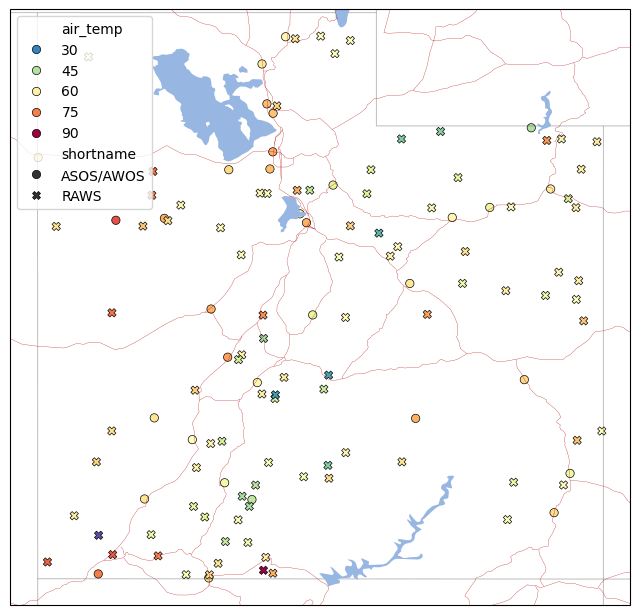

In [177]:
ax = EasyMap("10m", figsize=(8, 8)).STATES().LAKES().ROADS().ax
art = sns.scatterplot(
    df.filter(pl.col("longitude") < -60),  # One station has bad longitude metadata
    ax=ax,
    x="longitude",
    y="latitude",
    hue="air_temp",
    style="shortname",
    edgecolor="k",
    palette="Spectral_r",
)